In [1]:
import numpy as np
import itertools
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Categorical
from typing import Type, Any, Callable, Union, List, Optional
import gym
import gym_Aircraft
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
n_episodes = 1000
succeed_coef = 7000         # maximum reward when agent avoids collision
collide_coef = -1000        # reward when agent doesn't avoid collision
change_cmd_penalty = -100   # reward when agent changes command values
cmd_penalty = -0.05         # coefficient of penaly on using command
lr = 0.002
betas = (0.9, 0.999)
gamma = 0.99                # discount factor
K_epochs = 4                # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
max_timesteps = 300
env_name = "acav-v0"
env = gym.make(env_name)
env.env.__init__(succeed_coef, collide_coef, change_cmd_penalty, cmd_penalty)

In [3]:
dist_sep = 100

In [4]:
def avoid_function(state):
    r, vc, los, daz, dlos = state
    min_dist_vert = r*r/vc*dlos
    min_dist_horiz = r*r/vc*daz
    dist_cruise = r*los
    
    if min_dist_vert>0:
        if min_dist_vert<dist_sep:
            if np.abs(dist_cruise)<dist_sep:
                if (min_dist_horiz <dist_sep):
                    action = 1
                else:
                    action = 0
            else:
                action = 0
        else:
            if np.abs(dist_cruise)>dist_sep:
                action = 0
            else:
                action = 1
    else:
        if min_dist_vert>-dist_sep:
            if np.abs(dist_cruise)<dist_sep:
                if min_dist_horiz <dist_sep:
                    action = 2
                else:
                    action = 0
            else:
                action = 0
        else:
            if np.abs(dist_cruise)>dist_sep:
                action = 0
            else:
                action = 2
    return action

In [5]:
total_res=[]
rewards   = []
for ep in range(1, n_episodes+1):
    res_list = np.zeros(11)
    ep_reward = 0
    state = env.reset()
    for t in range(max_timesteps):
        action = avoid_function(state)
        state, reward, done, info = env.step(action)
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list,height_diff = info["info"]
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        ep_reward += reward
        if done:
            res_list=np.delete(res_list,0,0)
            total_res.append(res_list)
            rewards.append(ep_reward)
            break

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [6]:
min_distance = []
for i in range (n_episodes):
    min_distance.append(min(total_res[i][:,1]))

In [7]:
np.mean(min_distance)

137.90730423696945

In [10]:
np.var(min_distance)

952.6360846295562

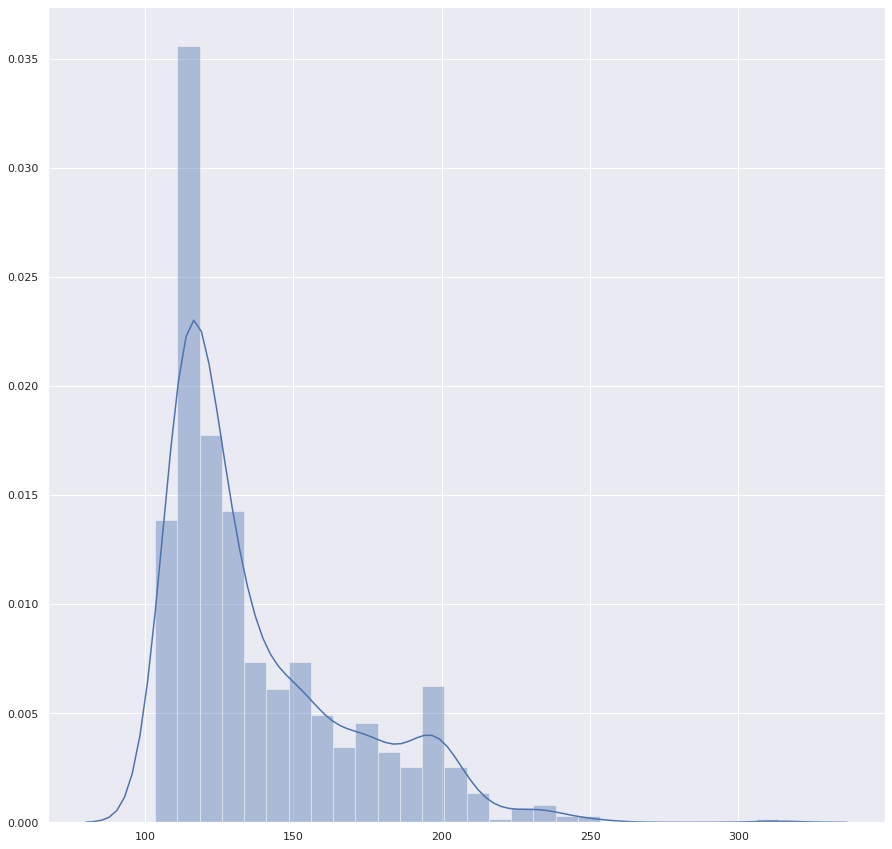

In [8]:
plt.figure(figsize=(15,15))
sns.set(color_codes=True)
sns.distplot(min_distance)

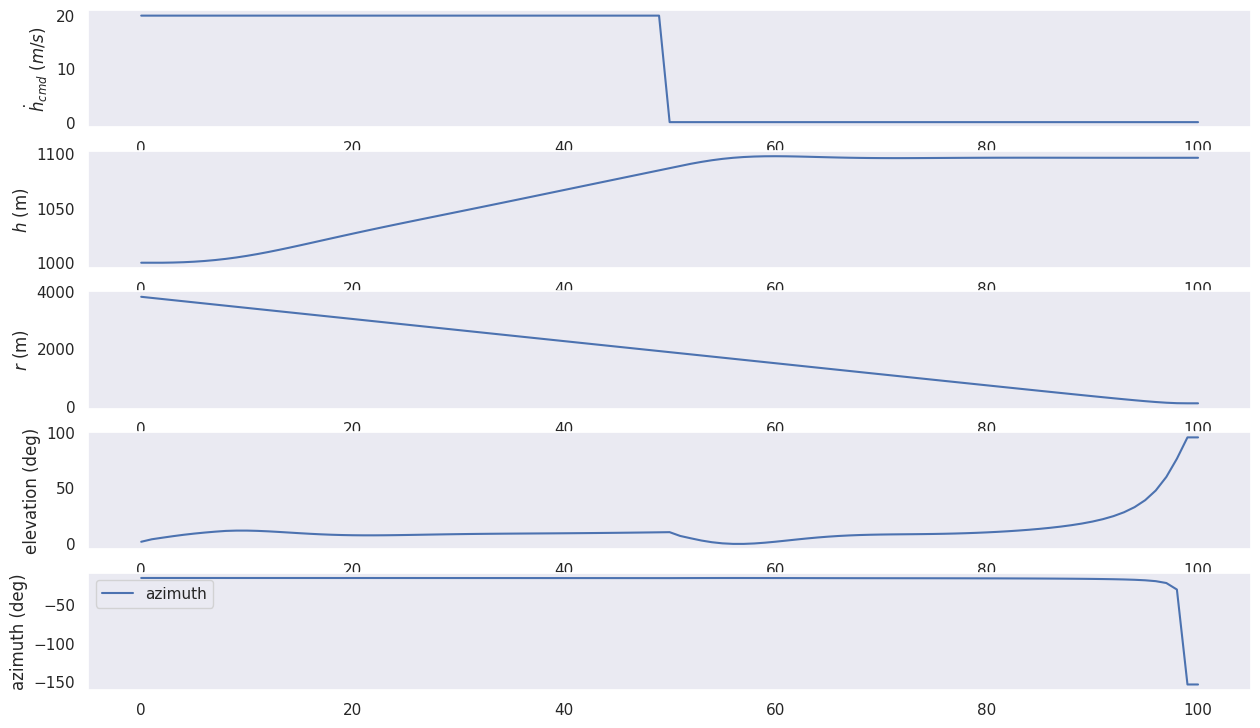

In [9]:
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[10]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()